First of all, let us import some of our favourite Python packages: numpy, astropy and poliastro!



In [1]:
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris

solar_system_ephemeris.set("jpl")

import numpy as np

from poliastro.bodies import Sun, Earth, Jupiter
from poliastro.ephem import Ephem
from poliastro.frames import Planes
from poliastro.maneuver import Maneuver
from poliastro.plotting import StaticOrbitPlotter
from poliastro.twobody import Orbit
from poliastro.util import norm, time_range

All the data for Juno’s mission is sorted here. The main maneuvers that the spacecraft will perform are listed down:

Inner cruise phase 1: This will set Juno in a new orbit around the sun.

Inner cruise phase 2: Fly-by around Earth. Gravity assist is performed.

Inner cruise phase 3: Jupiter insertion maneuver.

Let us first define the main dates and other relevant parameters of the mission:

([<matplotlib.lines.Line2D at 0x1e5b86e0880>],
 <matplotlib.lines.Line2D at 0x1e5b86e0b20>)

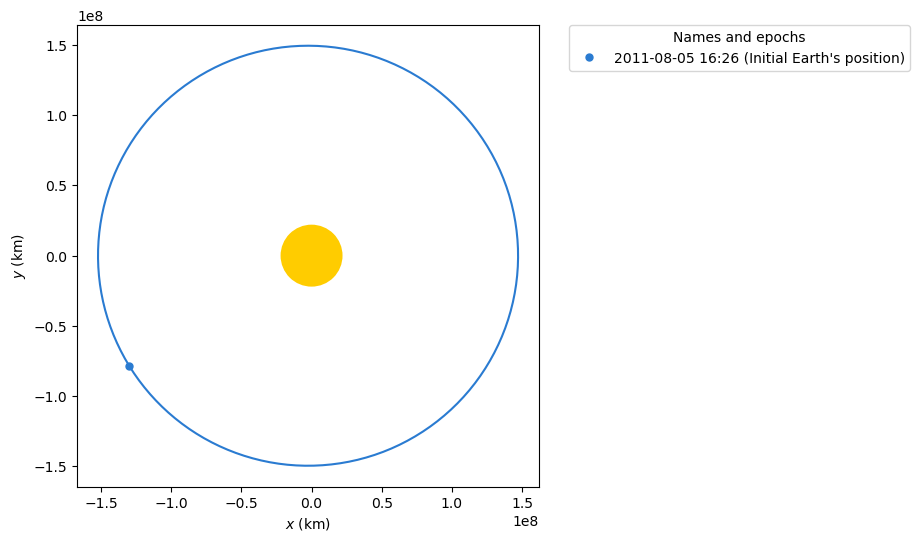

In [2]:
    ## Main dates
date_launch = Time("2011-08-05 16:25", scale="utc").tdb
date_flyby = Time("2013-10-09 19:21", scale="utc").tdb
date_arrival = Time("2016-07-05 03:18", scale="utc").tdb

# Atlas V supplied a launch energy
C_3 = 31.1 * u.km**2 / u.s**2

# Plot initial Earth's position
Earth.plot(date_launch, label="Initial Earth's position")

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import get_body_barycentric, solar_system_ephemeris

def calculate_planetary_distances(start_date, end_date, time_step=1):
    """
    Calculates the Earth-Mars, Mars-Jupiter, and combined distances over time.

    Parameters
    ----------
    start_date : str
        Start date in ISO format, e.g. "1900-01-01".
    end_date : str
        End date in ISO format, e.g. "2000-01-01".
    time_step : int, optional
        Time step in days (default is 1 day).

    Returns
    -------
    times : np.ndarray
        Array of Julian dates.
    dist_earth_mars : np.ndarray
        Earth-Mars distances in AU.
    dist_mars_jupiter : np.ndarray
        Mars-Jupiter distances in AU.
    dist_sum : np.ndarray
        Combined Earth->Mars->Jupiter distances in AU.
    """

    # Use built-in ephemeris data
    solar_system_ephemeris.set('builtin')

    # Generate an array of times from start_date to end_date with given time step
    times = Time(np.arange(Time(start_date).jd, Time(end_date).jd, time_step), format='jd')

    # Initialize lists to store distances
    dist_earth_mars = np.zeros(len(times))
    dist_mars_jupiter = np.zeros(len(times))
    dist_sum = np.zeros(len(times))

    # Loop over each time point and calculate distances
    for i, t in enumerate(times):
        # Get barycentric coordinates of Earth, Mars, and Jupiter at time t
        earth_pos = get_body_barycentric('earth', t)
        mars_pos = get_body_barycentric('mars', t)
        jupiter_pos = get_body_barycentric('jupiter', t)

        # Compute distances
        d_em = np.linalg.norm((earth_pos.xyz - mars_pos.xyz).to(u.AU).value)
        d_mj = np.linalg.norm((mars_pos.xyz - jupiter_pos.xyz).to(u.AU).value)


        # Store distances
        dist_earth_mars[i] = d_em
        dist_mars_jupiter[i] = d_mj
        dist_sum[i] = d_em + d_mj

    return times.value, dist_earth_mars, dist_mars_jupiter, dist_sum

# Compute distances from 1900 to 2000 with 1-day time step
times, dist_earth_mars, dist_mars_jupiter, dist_sum = calculate_planetary_distances("1900-01-01", "2000-01-01", time_step=1)



In [23]:
from scipy.signal import find_peaks

day_of_smallest_distance = times[np.argmin(dist_sum)]
peaks_earth_mars, _ = find_peaks(dist_earth_mars)
peaks_mars_jupiter, _ = find_peaks(dist_mars_jupiter)
peaks_sum, _ = find_peaks(dist_sum)

# Find the indices of the lows (valleys) by negating the distance arrays
lows_earth_mars, _ = find_peaks(-dist_earth_mars)
lows_mars_jupiter, _ = find_peaks(-dist_mars_jupiter)
lows_sum, _ = find_peaks(-dist_sum)

# Convert Julian dates of lows to standard calendar dates
calendar_dates_lows_earth_mars = Time(times[lows_earth_mars], format='jd').iso
calendar_dates_lows_mars_jupiter = Time(times[lows_mars_jupiter], format='jd').iso
calendar_dates_lows_sum = Time(times[lows_sum], format='jd').iso

# Print the first 5 lows in combined distances
print("First 5 Lows in combined distances (Calendar Dates):")
for jd, date in zip(times[lows_sum][:5], calendar_dates_lows_sum[:5]):
    print(f"Julian Date: {jd} -> Calendar Date: {date}")


First 5 Lows in combined distances (Calendar Dates):
Julian Date: 2415691.5 -> Calendar Date: 1901-11-03 00:00:00.000
Julian Date: 2416492.5 -> Calendar Date: 1904-01-13 00:00:00.000
Julian Date: 2417292.5 -> Calendar Date: 1906-03-23 00:00:00.000
Julian Date: 2417765.5 -> Calendar Date: 1907-07-09 00:00:00.000
Julian Date: 2418148.5 -> Calendar Date: 1908-07-26 00:00:00.000


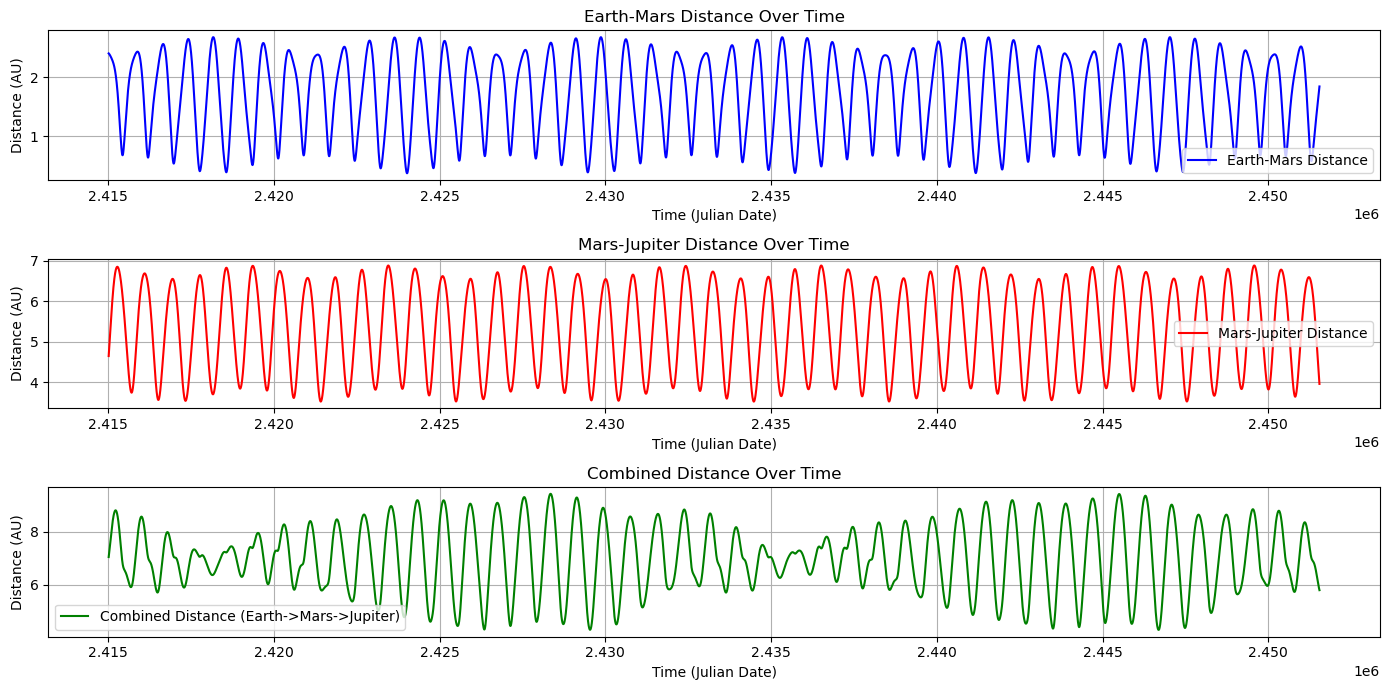

In [19]:
# Plot the distances
plt.figure(figsize=(14, 7))

# Plot Earth-Mars distances
plt.subplot(3, 1, 1)
plt.plot(times, dist_earth_mars, label='Earth-Mars Distance', color='b')
plt.xlabel('Time (Julian Date)')
plt.ylabel('Distance (AU)')
plt.title('Earth-Mars Distance Over Time')
plt.legend()
plt.grid(True)

# Plot Mars-Jupiter distances
plt.subplot(3, 1, 2)
plt.plot(times, dist_mars_jupiter, label='Mars-Jupiter Distance', color='r')
plt.xlabel('Time (Julian Date)')
plt.ylabel('Distance (AU)')
plt.title('Mars-Jupiter Distance Over Time')
plt.legend()
plt.grid(True)

# Plot combined distances
plt.subplot(3, 1, 3)
plt.plot(times, dist_sum, label='Combined Distance (Earth->Mars->Jupiter)', color='g')
plt.xlabel('Time (Julian Date)')
plt.ylabel('Distance (AU)')
plt.title('Combined Distance Over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()